In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [3]:
df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/power_consumption.csv', parse_dates=['Date'])
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2010-01-11,00:00:00,1.368,0.080,246.50,5.6,0.0,0.0,1.0
1,2010-01-11,00:01:00,1.368,0.080,246.55,5.6,0.0,0.0,1.0
2,2010-01-11,00:02:00,1.366,0.080,246.46,5.6,0.0,0.0,1.0
3,2010-01-11,00:03:00,1.312,0.000,246.20,5.4,0.0,0.0,0.0
4,2010-01-11,00:04:00,1.268,0.062,246.10,5.2,0.0,0.0,1.0


In [4]:
df = df.assign(Active_energy = lambda x: (x['Global_active_power']*1000/60-x['Sub_metering_1']-x['Sub_metering_2']-x['Sub_metering_3']))
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Active_energy
0,2010-01-11,00:00:00,1.368,0.080,246.50,5.6,0.0,0.0,1.0,21.800000
1,2010-01-11,00:01:00,1.368,0.080,246.55,5.6,0.0,0.0,1.0,21.800000
2,2010-01-11,00:02:00,1.366,0.080,246.46,5.6,0.0,0.0,1.0,21.766667
3,2010-01-11,00:03:00,1.312,0.000,246.20,5.4,0.0,0.0,0.0,21.866667
4,2010-01-11,00:04:00,1.268,0.062,246.10,5.2,0.0,0.0,1.0,20.133333


In [12]:
# normalize the dataset
dataset = df[['Active_energy']].astype('float32')

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [15]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

6753 3327


In [16]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [17]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [18]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [19]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
6751/6751 - 12s - loss: 0.0025 - 12s/epoch - 2ms/step
Epoch 2/100
6751/6751 - 10s - loss: 0.0010 - 10s/epoch - 1ms/step
Epoch 3/100
6751/6751 - 10s - loss: 0.0010 - 10s/epoch - 1ms/step
Epoch 4/100
6751/6751 - 10s - loss: 9.9227e-04 - 10s/epoch - 1ms/step
Epoch 5/100
6751/6751 - 10s - loss: 9.9230e-04 - 10s/epoch - 1ms/step
Epoch 6/100
6751/6751 - 10s - loss: 9.9418e-04 - 10s/epoch - 1ms/step
Epoch 7/100
6751/6751 - 10s - loss: 9.8960e-04 - 10s/epoch - 1ms/step
Epoch 8/100
6751/6751 - 10s - loss: 9.8821e-04 - 10s/epoch - 1ms/step
Epoch 9/100
6751/6751 - 10s - loss: 9.8008e-04 - 10s/epoch - 1ms/step
Epoch 10/100
6751/6751 - 10s - loss: 9.9611e-04 - 10s/epoch - 1ms/step
Epoch 11/100
6751/6751 - 10s - loss: 9.8740e-04 - 10s/epoch - 1ms/step
Epoch 12/100
6751/6751 - 10s - loss: 9.8681e-04 - 10s/epoch - 1ms/step
Epoch 13/100
6751/6751 - 10s - loss: 9.8193e-04 - 10s/epoch - 1ms/step
Epoch 14/100
6751/6751 - 10s - loss: 9.8868e-04 - 10s/epoch - 1ms/step
Epoch 15/100
6751/6751 - 10

In [20]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

104/104 [==============================] - 0s 2ms/step
Train Score: 2.22 RMSE
Test Score: 2.38 RMSE


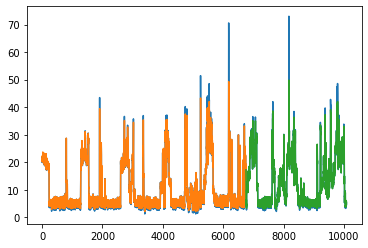

In [21]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()